# Short implementation of MLMC of EVPPI (Giles, Goda 2017). 
NOTICE: code is not optimized for performance.

In [1]:
### import packages in advance ###
import numpy as np
from matplotlib import pyplot as plt

### for code optimization, you might not need this to compute EVPPI ###
from numba import jit

The estimation of Expected Value of Partial Perfect Infomation (EVPPI) has a variety of applications, such as the estimation of the cost effectiveness of medical research, boring survey of oil reservior. However, the estimation of EVPPI had been computationally very costly, since the form of the estimator is the expectation of the nested expectation. In the past it was computed using nested monte carlo with the computational cost of $O(\varepsilon^{-3})$ to achinve the accuracy of $\varepsilon$ ($MSE\leq \varepsilon^{-2}$). 

In 2017, Giles and Goda computed this using Multi Level Monte Carlo method and achieved computational complexity of $O(\varepsilon^{-2})$, which is drastically faster than the conventional nested monte carlo. This notebook is meant to be a short replication of the numerical experiment given in the original paper ([Giles, Goda 2017](https://arxiv.org/abs/1708.05531?context=math)).

## 1. Theoretical Aspect of MLMC of EVPPI

### 1.1 Definition of Variables

| Variable | Explanation |
|:-----------|:------------|
|$X, Y$| Random variables.|
|$d \in D$|Decision of the given decision set $D$.|
|$f_d(X,Y)$|Utility Function of the decision $d$, given $X,Y$.|
|$\displaystyle{ EVI = \mathbb{E}_{X}[\max_{d \in D}{f_d(X)}] - \max_{d \in D}{\mathbb{E}_{X}[f_d(X)]}}$|Expected value of information of $X$.|
|$\displaystyle EVPI = \mathbb{E}_{X,Y}[\max_{d \in D}{f_d(X,Y)}] - \max_{d \in D}{\mathbb{E}_{X,Y}[f_d(X,Y)]}$|Expected value of perfect information of $X,Y$.|
|$\displaystyle EVPPI = \mathbb{E}_{X}[\max_{d \in D}{\mathbb{E}_{Y \mid X}[f_d(X,Y)]}] - \max_{d \in D}{\mathbb{E}_{X,Y}[f_d(X,Y)]}$|Expected value of partial perfect information of $X,Y$<br> (expected value of information of $X$ without information of $Y$).|
|$\displaystyle P =\mathbb{E}_{Y \mid X}[\max_{d \in D}{f_d(X,Y)}] - \max_{d \in D}{\mathbb{E}_{Y \mid X}[f_d(X,Y)]}$|Inner conditional expectation of $EVPI - EVPPI$, with underlying random variable $X$.<br>Here $P$ satisfies $\mathbb{E}_{X}[P] = EVPI - EVPPI$.|
|$\displaystyle P_l = \scriptsize \overline{\max_{d \in D}f_d(X)}^{1:2^{l}}  - \max_{d \in D}{ \overline{f_d(X)}^{1:2^{l}}} $ $ \displaystyle = \scriptsize \frac{1}{2^l}\sum_{i=1}^{2^l}{\max_{d \in D}{f_d(X,Y^{(i)})}} - \max_{d \in D}{\frac{1}{2^l}\sum_{i=1}^{2^l}{f_d(X,Y^{(i)})}}  $|A consistent estimator of $P$ given $X$ ($\Leftrightarrow P_l \xrightarrow{p.} P$ ), with underlying random variable $Y^{(1)}, \ldots ,Y^{(2^l)}$ and $X$. <br>Note that $\mathbb{E}_{X}[P_l] \xrightarrow{p.} \mathbb{E}_{X}[P] = EVPI - EVPPI$ as $l \to \infty$.|
|$\displaystyle Z_l  = \scriptsize  \frac{1}{2} \left[   \max_{d \in D}{ \overline{f_d(X)}^{1:2^{l-1}}} + \max_{d \in D}{\overline{f_d(X)}^{2^{l-1}+1:2^{l}}}  \right]  - \max_{d \in D}{ \overline{f_d(X)}^{1:2^{l}}} $ $ \displaystyle = \scriptsize \frac{1}{2} \left[  \max_{d \in D}{ \frac{1}{2^{l-1}}\sum_{i=1}^{2^{l-1}}f_d(X,Y^{(i)})}  + \max_{d \in D}{ \frac{1}{2^{l-1}}\sum_{i=1}^{2^{l-1}}f_d(X,Y^{(i)})} \right] - \max_{d \in D}{ \frac{1}{2^{l}}\sum_{i=1}^{2^{l}}f_d(X,Y^{(i)})}  $|This is an unbiased estimator of $\mathbb{E}_{Y \mid X}[P_l-P_{l-1}] $ given $X$. Here, $ \mathbb{E}_{Y \mid X}[P_l-P_{l-1}] $ $= \mathbb{E}_{Y \mid X}[P_l] - \mathbb{E}_{Y \mid X}[P_{l-1}] $ $= \mathbb{E}_{Y^{(l,1)}, \ldots ,Y^{(l,2^l)} \mid X}[P_l] - \mathbb{E}_{Y^{(l-1,1)}, \ldots ,Y^{(l-1,2^{l-1})} \mid X}[P_{l-1}]$ <br>So, it is clear that $Z_l(X, Y^{(1)}, \ldots , Y^{(2^l)} )$is an unbiased estimator of $\mathbb{E}_{X,Y}[P_l-P_{l-1}]$|
|$C[Z_l]$|Computational cost of sampling one example of $Z_l$, which is $O( 2^l )$ for fixed $\lvert D \rvert$.
|$\displaystyle \hat{Z}^{(L)} =  \sum_{l=1}^{L}{\hat{Z}_l}$<br>Here, $ \displaystyle  \hat{Z}_l = \frac{1}{N_l}\sum_{n=1}^{N_l}{Z_l(X^{(n, l)}, Y^{(1, n, l)}, Y^{(2, n, l)}, \ldots , Y^{(2^l, n, l)} )} $, and $ N_1, \ldots ,N_L$ are determined by MLMC algolithm (Giles 2015) explained in the Section 1.3. |$\hat{Z}^{(L)}$ is a MLMC estimator of $ \mathbb{E}_{X}[P]=EVPI - EVPPI$. <br>This is because $\hat{Z}^{(L)}$ is an unbiased estimator of $\mathbb{E}_{X,Y}[P_L] = \sum_{l=1}^{L}{\mathbb{E}_{X,Y}[P_l-P_{l-1}]}$ since $\hat{Z}_l$ is an unbiased estimator of $\mathbb{E}_{X,Y}[P_l-P_{l-1}]$ and $\mathbb{E}_{X,Y}[P_0]=0$.



### 1.2 Mechnism and Algorithm of MLMC Estimation

In order to take advantage of MLMC when estimating $EVPPI$, we constitute the MLMC estimator of $EVPI−EVPPI$ instead of the estimator of $EVPPI$ itself. It is because we can reduce the varianvce of MLMC estimator by doing so, and we also can estimate $EVPI$ by  accuracy of $\varepsilon$ ( or $\varepsilon_{\text{total}} / \sqrt{2}$ ) with computational complexity of $O(\varepsilon^{-2})$. So we will focus on estimating $EVPI - EVPPI$ with as close cost to $O(\varepsilon^{-2})$ as possible. 


Here, the main theorem of the [Giles, Goda 2017](https://arxiv.org/abs/1708.05531?context=math) guarantees that under appropriate ragular conditions regerding the utility function, we can use MLMC algorithm in [Giles 2015](https://www.cambridge.org/core/journals/acta-numerica/article/multilevel-monte-carlo-methods/C5AF9A57ED8FF8FDF08074C1071C5511) to achieve optimal comlexity of $O(\varepsilon^{-2})$ (otherwise, without that regular condition, complexity is $O(\varepsilon^{-2}(\log{\varepsilon})^2)$).

As we can see, $\hat{Z}^{(L)}$ is an unbiased estimator of $\mathbb{E}_{X,Y}[P_L]$, and $\mathbb{E}_{X}[P_l] \xrightarrow{p.} EVPI - EVPPI$. Therefore we can use $\hat{Z}^{(L)}$ as (biased) estimater of $EVPI - EVPPI$. When estimating $EVPI - EVPPI$ with accuracy of $\varepsilon$ , we want
$$MSE = \mathbb{E}_{X,Y}\left[\{ (EVPI - EVPPI) - \hat{Z}^{(L)} \}^2 \right] = \sum_{l=1}^{L}{\frac{\mathbb{V}_{X,Y}[ Z_l(X,Y) ]}{N_l}} + Bias_{\hat{Z}^{(L)}} \leq \varepsilon^2.$$
Here bias-variance decomposition is used in the second equality. And this can be replaced by stronger condition, 
$$\sum_{l=1}^{L}{\frac{\mathbb{V}_{X,Y}[ Z_l(X,Y) ]}{N_l}} \leq \frac{\varepsilon^2}{2} \ \ \text{and} \ \ Bias_{\hat{Z}^{(L)}} \leq \frac{\varepsilon^2}{2}.$$

In the MLMC algorithm, we need to determine both the level $L$ and the number of outer iteration $N_l$ of the estimator $\hat{Z}_l$ to build estimaer $\hat{Z}^{(L)}$. In order to do that, (1) we estimate $Bias_{\hat{Z}^{(L)}}$ for each $L=1,2,3, \ldots$, and check whether it satisfies $Bias_{\hat{Z}^{(L)}} \leq \varepsilon/2$. (2) Then for the smallest level $L$ that satisfies the condition about the bias term, we compute the optimal $N_1, \ldots ,N_L$ that achieves $\sum_{l=1}^{L}{\frac{\mathbb{V}_{X,Y}[ Z_l(X,Y) ]}{N_l}} \leq \varepsilon^2/2$ with least cost. (3) Finally, the $L$ and the $N_1, \ldots ,N_L$ can be used to constitute estimator $\hat{Z}^{(L)}$ whose computational cost is $O(\varepsilon^{-2})$.

#### (1) Bias estimation and Level Selection

Estimating bias term is a bit heuristic, since there are no defacto-standard procedure of the estimation of the bias. However, the main theorem of the [Giles, Goda 2017](https://arxiv.org/abs/1708.05531?context=math) gaurantees the following two inequality under ragular condition.
$$\mathbb{E}[ Z_l ] \simeq o \left(2^{-l}\right)$$
So we can expect there exists some $c$ such that $\mathbb{E}[ Z_l ] \simeq c2^{-l}$. Then we get 
$$Bias_{\hat{Z}^{(L)}} = \left( \sum_{l = L+1}^{\infty}\mathbb{E}[ P_{l} - P_{l-1} ] \right)^2= \left( \sum_{l = L+1}^{\infty}\mathbb{E}[ Z_l ] \right)^2 \simeq \left( \mathbb{E}[ Z_L ]\sum_{l' = 1}^{\infty}2^{-l'}\right)^2 = \mathbb{E}[ Z_L ]^2 \leq \frac{\varepsilon^2}{2}.$$
Thus we will compute $\mathbb{E}[ Z_L ]$ for $L=1,2,3,...$, until we find $L$ which satisfies $\mathbb{E}[ Z_L ] \leq \varepsilon / 2$. The estimation of $\mathbb{E}[ Z_L ]$ will be done using standard monte carlo approximation, 
$$\frac{1}{N}\sum_{n=1}^{N}{Z_L(X^{(n, L)}, Y^{(1, n, L)},  \ldots , Y^{(2^L, n, L)} )} \xrightarrow{p.}\mathbb{E}[ Z_L ].$$



#### (2) Finding Optimal $N_l$

When we have fixed the level L, derivation of the optimal $N_1, \ldots ,N_L$ can be easily done by using Lagrange multiplier method. The "cost of computing $\hat{Z}^{(L)}$" is minimized with constraint of "variance term" being $\varepsilon^2/2$, namely,
$$\min_{N_1, \ldots , N_L}{\sum_{l=1}^{L}{N_l C[Z_l]}} \ \ s.t. \ \ \sum_{l=1}^{L}{\frac{\mathbb{V}[ Z_l ]}{N_l}}=\frac{\varepsilon^2}{2}.$$
Here, we relaxed the integer condition of $N_1, \ldots , N_L$. Then we get 
$$\hat{N_l} = 2\varepsilon^{-2} \sqrt{{\mathbb{V}[ Z_l ] } \ /\ { C[Z_l] }}\left(  \sum_{l=0}^{L}{\sqrt{\mathbb{V}[ Z_l ]C[Z_l]}} \right). $$
Thus we use $\scriptsize \left\lceil \hat{N_l} \right\rceil $ as the number of inner iteration of the MLMC estimator. By doing so, we get total cost of
$$ \sum_{l=1}^{L}{\hat{N_l} C[Z_l]} = 2\varepsilon^{-2} \left(  \sum_{l=0}^{L}{\sqrt{\mathbb{V}[ Z_l ]C[Z_l]}} \right)^2.$$
This total cost of evaluating $EVPI-EVPPI$ is $O(\varepsilon^{-2})$, since the squred summation term is proved to be finite. The main theorem of the [Giles, Goda 2017](https://arxiv.org/abs/1708.05531?context=math) proves $\mathbb{V}[ Z_l ] \simeq O \left(2^{-\frac{3}{2}l}\right)$ and since $C[Z_l] = O(2^l)$, we can see
$$\sum_{l=0}^{L}{\sqrt{\mathbb{V}[ Z_l ]C[Z_l]}} \leq \sum_{l=0}^{\infty}{O(2^{-\frac{1}{4}l})} < \infty$$

#### (3) Computing Estimator

We can plug in the values we got, and  $\hat{Z_l}^{(L)}$ is easily computed. <br>Then by subtracting the estimate of $EVPI-EVPPI$ (, which is  $\hat{Z_l}^{(L)}$,) from $EVPI$, We get the estimate of $EVPPI$.

## 2. Implementation

Our goal is to build function `EVPI_estimator` and `EVPI_minus_EVPPI_estimator` that takes arbitary accuracy `epsilon` as input and returns the estimate with that accuracy. Then we can easily implement the function `EVPPI_estimator` that estimates the $EVPPI$ with accuracy `epsilon_total`.

### 2.1 Overview of Functions and Variables in the code
Following are the functions implemented.

| Function / Variable | Input | Output | Notation | Explanation |
|:-------------------:|:------|:-------|:---------|:------------|
| `L` | - | Integer (not function) | $L$ | Total levels of the MLMC. |
| `epsilon` | - | float (not function) | $\varepsilon$ | The upper bound of $\sqrt{MSE}$. |
| `D` | - | Tuple of integer (not function) | $D$ | Decision set $D$. |
| `f(array_1d_dXY)` |  1 dimentional np.array <br>`np.array([d, X1, X2, ..., Y1, Y2, ...])` | Float | $f_d(X,Y)$ | The utility function to be evaluated. |
| `X_sampler(shape)` | Tuple `(N1,N2,...,Nm)`  | m+1 dimentional np.ndarray | $X^{(n_1,\ldots,n_m)} = (X^{(n_1,\ldots,n_m)}_1, \ldots , X^{(n_1,\ldots,n_m)}_{p_X})$<br>$\forall n_i = 1,\ldots,N_i \ (\forall i=1,\ldots,m)$| Sample $X^{(n_1,\ldots,n_m)} = (X^{(n_1,\ldots,n_m)}_1, \ldots , X^{(n_1,\ldots,n_m)}_{p_X})$. Here, we assume the dimention of the $X^{(i,n,l)}$ to be $p_X$. |
| `Y_sampler(shape)` | Tuple `(N1,N2,...,Nm)`  | m+1 dimentional np.ndarray | $Y^{(n_1,\ldots,n_m)} = (Y^{(n_1,\ldots,n_m)}_1, \ldots , Y^{(n_1,\ldots,n_m)}_{p_Y})$<br>$\forall n_i = 1,\ldots,N_i \ (\forall i=1,\ldots,m)$| Sample $Y^{(n_1,\ldots,n_m)} = (Y^{(n_1,\ldots,n_m)}_1, \ldots , Y^{(n_1,\ldots,n_m)}_{p_Y})$. Here, we assume the dimention of the $Y^{(i,n,l)}$ to be $p_Y$. |
| `Z_sampler(l,Nl)` | Integer `l`, `Nl` | 1 dimentional np.ndarray | $Z_l^{(n)}=Z_l(X^{(n, l)}, Y^{(1, n, l)}, Y^{(2, n, l)}, \ldots , Y^{(2^l, n, l)} )$<br> $\forall n = 1,\ldots,N_l$ |Notice that `Zn` is the dictionary of the function `Z_sampler[1]` , ... , `Z_sampler[L]`. <br>Here, `D , f, X_sampler, Y_sampler` is used to build this sampler function. |
| `EZ[l]`| - | Float (not function) | $\mathbb{E}_{X,Y}[Z_l(X,Y)]$ | Notice that `EZ` is the dictionary of the value `EZ[1]` , ... , `EZ[L]`. |
| `VZ[l]`| - | Float (not function) | $\mathbb{V}_{X,Y}[Z_l(X,Y)]$ | Notice that `VZ` is the dictionary of the value `VZ[1]` , ... , `VZ[L]`. |
| `CZ[l]` | - |Float (not function) | $C[Z_l]$ | Notice that `Zn` is the dictionary of the value `CZ[1]` , ... , `CZ[L]`. |
| `Nhat[l]` | - |Float (not function) | $\left\lceil \hat{N_l} \right\rceil $ | Notice that `Nhat` is the dictionary of the value `Nhat[1]` , ... , `Nhat[L]`. |
| `EVPI_minus_EVPPI_estimator(epsilon, D , f, X_sampler, Y_sampler)` | Float `epsilon`, tuple `D` and function `f`, `X_sampler`, `Y_sampler` | Dictinary | $\hat{Z}^{(L)} = \hat{EVPI-EVPPI}_{\text{with accuracy } \varepsilon } $  <br> and so on | - |
| `EVPI_estimator(epsilon, D , f, X_sampler, Y_sampler)` | Float `epsilon`, tuple `D` and function `f`, `X_sampler`, `Y_sampler` | Dictionary | $\displaystyle {\overline {\max_{d \in D}{f_d}} - \max_{d \in D}{\overline{f_d}}}_{\text{with accuracy } \varepsilon}$ <br>and so on| - |
| `EVPPI_estimator(epsilon, D , f, X_sampler, Y_sampler)` | Float `epsilon`, tuple `D` and function `f`, `X_sampler`, `Y_sampler` | Dictinary | $\hat{EVPPI}_{\text{with accuracy } \varepsilon } $  <br> and so on | Estimate $EVPPI$ with standard MLMC. |
|`EVPPI_estimator_StdMC(Nx, Ny, D , f, X_sampler, Y_sampler)`| Integer `Nx`, `Ny`, tuple `D` and function `f`, `X_sampler`, `Y_sampler` | Float | $\hat{EVPPI}_{\text{with #sample } N_x, N_y }$ | Estimate $EVPPI$ with standard MC. |

### 2.2 Functions for EVPI estimation

In [2]:
def EVPI_estimator_given_N(N, D, f, X_sampler, Y_sampler):
    ### d.shape == (|D|, N, 1) 
    ### X.shape == (|D|,N, dimX), 
    ### Y.shape == (|D|,N, dimY)
    d = np.array(D).reshape((len(D), 1, 1))*np.ones((1, N, 1))
    X = X_sampler((1,N))*np.ones((len(D), 1, 1))
    Y = Y_sampler((1,N))*np.ones((len(D), 1, 1))

    ###  dxy.shape == (|D|,N, 1+dimX+dimY )
    dXY = np.concatenate([d,X,Y], axis=2)
    
    ### f_values.shape ==  (|D|, N)
    f_values = np.apply_along_axis(func1d=f, axis=2, arr=dXY)
    
    meanXY_max = f_values.max(axis=0).mean()
    max_meanXY = f_values.mean(axis=1).max()
    EVPI = meanXY_max - max_meanXY
    
    return EVPI

In [3]:
def EVPI_estimator(epsilon, D , f, X_sampler, Y_sampler):
    ### We use N0 to estimate the error of the stdMC estimator
    N0 = 50
    Var_N0 = np.array([EVPI_estimator_given_N(N0, D , f, X_sampler, Y_sampler) for i in range(50)]).var()
    Var_1 = Var_N0*N0
    N = int(Var_1/epsilon**2)+1
    EVPI = EVPI_estimator_given_N(N, D , f, X_sampler, Y_sampler)
    return {"N":N, "EVPI":EVPI}

### 2.3 Functions for EVPI - EVPPI estimation

In [4]:
def Z_sampler(l,Nl, D , f, X_sampler, Y_sampler):
    Nx = Nl
    Ny = 2**l
    ### d.shape == (|D|, Nx, Ny, 1) 
    ### X.shape == (|D|,Nx, Ny, dimX), 
    ### Y.shape == (|D|,Nx, Ny, dimY)
    d = np.array(D).reshape((len(D), 1, 1, 1))*np.ones((1, Nx, Ny, 1))
    X = X_sampler((1,Nx,1))*np.ones((len(D),1,Ny,1))
    Y = Y_sampler((1,Nx,Ny))*np.ones((len(D), 1, 1,1))

    ###  dxy.shape == (|D|,Nx,Ny, 1+dimX+dimY )
    dXY = np.concatenate([d,X,Y], axis=3)
    
    ### f_values.shape ==  (|D|, Nx, Ny)
    f_values = np.apply_along_axis(func1d=f, axis=3, arr=dXY)
    
    ### max_1st_half_meanY.shape = (Nx) = (Nl)
    ### max_2nd_half_meanY.shape = (Nx) = (Nl)
    ### max_whole_meanY.shape = (Nx) = (Nl)
    max_1st_half_meanY = f_values[:,:,:2**(l-1)].mean(axis=2).max(axis=0)
    max_2nd_half_meanY = f_values[:,:,2**(l-1):].mean(axis=2).max(axis=0)
    max_whole_meanY    = f_values[:,:,:        ].mean(axis=2).max(axis=0)
    
    return (1/2) * (max_1st_half_meanY + max_2nd_half_meanY) - max_whole_meanY

In [5]:
def EVPI_minus_EVPPI_estimator(epsilon, D , f, X_sampler, Y_sampler):
    
    ### We first estimate the optimal level L for constructing MLMC estimator Zhat = EVPI-EVPPI
    Maximum_L = 15 ### other values will be fine
    Levels0 = [l+1 for l in range(Maximum_L)]
    dumpZ = {}
    EZ = {}
    VZ = {}
    CZ = {}
    
    for l in Levels0:
        dumpZ[l] = Z_sampler(l, 100, D , f, X_sampler, Y_sampler)
        EZ[l] = dumpZ[l].mean()
        VZ[l] = dumpZ[l].var()
        CZ[l] = 2**l
        ### Increase the level L, until the bias of Z_hat^(L) seems to get ignorable
        if EZ[l]**2 < epsilon**2/2:
            break
        elif l==Maximum_L:
            print("Maximum level reached. The result must be inaccurate. Please increase tha Maximum level and retry.")
    L = l
    Levels = [l+1 for l in range(L)]

    ### Next, we compute Nhat[]
    sum_VC_root = sum([(VZ[l]*CZ[l])**(0.5) for l in Levels])
    Nhat = {l: int(2*epsilon**(-2)*(VZ[l]/CZ[l])**0.5*sum_VC_root)+1 for l in Levels}

    ### Finally, we compute Zhat = EVPI-EVPPI
    EVPI_minus_EVPPI = sum([Z_sampler(l, Nhat[l], D , f, X_sampler, Y_sampler).mean() for l in Levels])
    result = {"EVPI_minus_EVPPI":EVPI_minus_EVPPI, "Nhat":Nhat, "EZ":EZ, "CZ":CZ, "VZ":VZ, "Total_C":sum([CZ[l]*Nhat[l] for l in Levels]) }
    return result

### 2.4 MLMC estimation of EVPPI

In order to estimate EVPPI with total MSE of estimator being less than $\varepsilon_{\text{total}}^2$, we estimate $EVPI$ and $EVPI-EVPPI$ with accuracy of $\varepsilon_{\text{total}} / \sqrt2$.

In [6]:
def EVPPI_estimator(epsilon_total, D , f, X_sampler, Y_sampler):
    result_EVPI =  EVPI_estimator(epsilon_total/2**0.5, D , f, X_sampler, Y_sampler)
    result_EVPI_minus_EVPPI = EVPI_minus_EVPPI_estimator(epsilon_total/2**0.5, D , f, X_sampler, Y_sampler)
    
    result = result_EVPI_minus_EVPPI
    result["Total_C"] = result_EVPI_minus_EVPPI["Total_C"] + result_EVPI["N"]
    
    EVPI = result_EVPI["EVPI"]
    EVPI_minus_EVPPI = result_EVPI_minus_EVPPI["EVPI_minus_EVPPI"]
    EVPPI = EVPI - EVPI_minus_EVPPI
    result["EVPPI"] = EVPPI
    
    result.pop("EVPI_minus_EVPPI")
    
    return result

### 2.5 Standard Monte Carlo estimation of EVPPI

In [7]:
def EVPPI_estimator_StdMC(Nx, Ny, D , f, X_sampler, Y_sampler):
    ### create list of 1 dimentional np.array to be fed in np.vectorize ###
    ### d.shape == (|D|, Nx, Ny, 1) 
    ### X.shape == (|D|,Nx, Ny, dimX), 
    ### Y.shape == (|D|,Nx, Ny, dimY)
    d = np.array(D).reshape((len(D), 1, 1, 1))*np.ones((1, Nx, Ny, 1))
    X = X_sampler((1,Nx,1))*np.ones((len(D),1,Ny,1))
    Y = Y_sampler((1,Nx,Ny))*np.ones((len(D), 1, 1,1))

    ###  dxy.shape == (|D|,Nx,Ny, 1+dimX+dimY )
    dXY = np.concatenate([d,X,Y], axis=3)
    
    ### f_values.shape ==  (|D|, Nx, Ny)
    f_values = np.apply_along_axis(func1d=f, axis=3, arr=dXY)

    meanX_max_meanY = f_values.mean(axis=2).max(axis=0).mean()
    max_meanX_meanY = f_values.mean(axis=(1,2)).max()
    EVPPI_stdMC = meanX_max_meanY - max_meanX_meanY
    return EVPPI_stdMC

## 3 Numerical Experiment

### 3.1 Condition

We use the first test case in the [Giles, Goda 2017](https://arxiv.org/abs/1708.05531?context=math), where $D=\{0,1\}$ and $X, Y \sim N(0,1)$, $f_0(X,Y) = 0$, $ f_1(X,Y)=X+Y$.<br>
Since we can analyticaly see that $$EVPPI = \int_{0}^{\infty}x \frac{1}{\sqrt{2\pi}}\exp{\left(\frac{1}{2}x^2\right)}dx = \frac{1}{\sqrt{2\pi}}$$,
we know that $EVPPI = 0.39894228...$.

In [8]:
### Initialize Constants and Utility Function ###
### d should be integer
D = (0,1)
epsilon_total = 0.001

def f(array_1d_dXY):
    d = array_1d_dXY[0]
    X1 = array_1d_dXY[1]
    Y1 = array_1d_dXY[2]
    return d*(X1+Y1)

### Initialize smpler of X and Y ###
### X2 and Y2 are not used this time.
def X_sampler(shape):
    X1 = np.random.randn(*shape)
    shape_index = tuple(i+1 for i in range(len(shape)))
    return np.array([X1]).transpose(*shape_index,0)
    
def Y_sampler(shape):
    Y1 = np.random.randn(*shape)
    shape_index = tuple(i+1 for i in range(len(shape)))
    return np.array([Y1]).transpose(*shape_index,0)
    

### 3.2 Computation and Result

This might take a few minutes.

In [9]:
%%time
result = EVPPI_estimator(epsilon_total, D , f, X_sampler, Y_sampler)

Wall time: 42.1 s


In [10]:
EVPPI = result["EVPPI"]
EVPPI

0.4002945665860228

### 3.3 Standard Monte Carlo (for sanity check)

In [11]:
%%time
Nx = 1000
Ny = 1000
EVPPI_StdMC = EVPPI_estimator_StdMC(Nx, Ny, D , f, X_sampler, Y_sampler)

Wall time: 9.75 s


In [12]:
EVPPI_StdMC

0.37026396170216747

We can see that our MLMC estimate is in good align with standard monte carlo result.

### 3.4 Computational Cost

Let's check the relation between the "accuracy" and the "total cost".<br>
The line graph below shows that the total cost are $O({\varepsilon_{\text{total}}}^{-2})$, for accuracy $\varepsilon_{\text{total}}$.

In [13]:
%%time
### This might take some minutes. ###
Accuracy_list = [2**(-i-3) for i in range(8)]
Cost_list = [EVPPI_estimator(epsilon_total, D , f, X_sampler, Y_sampler)["Total_C"] for epsilon_total in Accuracy_list]
Cost_list

Wall time: 1min 4s


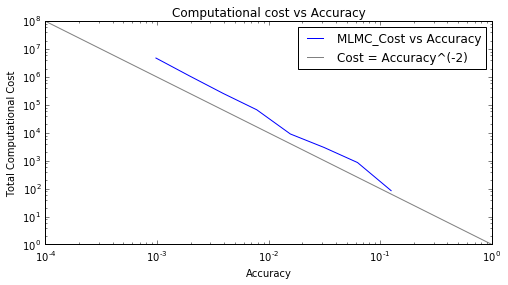

In [14]:
% matplotlib inline

plt.figure(figsize=(8, 4))
plt.xlabel("Accuracy")
plt.ylabel("Total Computational Cost")
plt.title("Computational cost vs Accuracy")
plt.xscale("log")
plt.yscale("log")
plt.plot(Accuracy_list , Cost_list)
plt.plot([1e-0,1e-4],[1e-0,1e+8],c="gray")
plt.legend(["MLMC_Cost vs Accuracy","Cost = Accuracy^(-2)"])
plt.show()

## 4 Appendix (More Complex Utility Function)

### 4.1 Use of Customized Function

The EVPPI for more complex utility functions can be computed like following.<br>
Here, we set $D=\{0,1\}$ and $X_1,...,X_4, Y_1,...,Y_4 \sim N(0,1)$, $f_0(X,Y) = 0$, $f_1 = \sum X_i + \sum Y_i$.

Since $\sum X_i, \sum Y_i \sim N(0,2)$, we can think that we have just scaled up the first test case by 2 times this time. <br>
So it is natural that the result we get this time is just about 2 times larger than the result of first case.

In [15]:
### Initialize Constants and Utility Function ###
### d should be integer
D2 = (0,1)
epsilon_total2 = 0.005

def f2(array_1d_dXY):
    d = array_1d_dXY[0]
    X1 = array_1d_dXY[1]
    X2 = array_1d_dXY[2]
    X3 = array_1d_dXY[3]
    X4 = array_1d_dXY[4]
    Y1 = array_1d_dXY[5]
    Y2 = array_1d_dXY[6]
    Y3 = array_1d_dXY[7]
    Y4 = array_1d_dXY[8]
    return d*(X1+X2+X3+X4+Y1+Y2+Y3+Y4)

### Initialize smpler of X and Y ###
### X2 and Y2 are not used this time.
def X_sampler2(shape):
    X1 = np.random.randn(*shape)
    X2 = np.random.randn(*shape)
    X3 = np.random.randn(*shape)
    X4 = np.random.randn(*shape)
    shape_index = tuple(i+1 for i in range(len(shape)))
    return np.array([X1,X2,X3,X4]).transpose(*shape_index,0)
    
def Y_sampler2(shape):
    Y1 = np.random.randn(*shape)
    Y2 = np.random.randn(*shape)
    Y3 = np.random.randn(*shape)
    Y4 = np.random.randn(*shape)
    shape_index = tuple(i+1 for i in range(len(shape)))
    return np.array([Y1,Y2,Y3,Y4]).transpose(*shape_index,0)

In [16]:
%%time
result2 = EVPPI_estimator(epsilon_total2, D2 , f2, X_sampler2, Y_sampler2)

Wall time: 11.9 s


In [17]:
EVPPI2 = result2["EVPPI"]
EVPPI2

0.79807143239268608

You can check if the result of standard monte carlo computation of EVPPI.

In [18]:
%%time
Nx2 = 1000
Ny2 = 1000
EVPPI_StdMC2 = EVPPI_estimator_StdMC(Nx2, Ny2, D2, f2, X_sampler2, Y_sampler2)

Wall time: 12.5 s


In [19]:
EVPPI_StdMC2

0.79616383628199705

### 4.2 Optimization of your Customized Function (for speeding up)

If we use larger function (e.g. the one that includes 'for loop'),  that can be bottleneck of the computation. <br>
So if that is the case for you, we should speed up that function using packages such as 'Cython' or 'Numba'. 
Below is the example of use of 'Numba'. 

In [20]:
@jit("f8(f8[:])")
def f2_100_jit(array_1d_dXY):
    d = array_1d_dXY[0]
    X1 = array_1d_dXY[1]
    X2 = array_1d_dXY[2]
    X3 = array_1d_dXY[3]
    X4 = array_1d_dXY[4]
    Y1 = array_1d_dXY[5]
    Y2 = array_1d_dXY[6]
    Y3 = array_1d_dXY[7]
    Y4 = array_1d_dXY[8]
    Sum = 0
    for i in range(100):
        Sum = Sum + d*(X1+X2+X3+X4+Y1+Y2+Y3+Y4)*(1/100)
    return Sum

If you implement the function above without 'Numba', it would run 10~20 times slower.

In [21]:
def f2_100(array_1d_dXY):
    d = array_1d_dXY[0]
    X1 = array_1d_dXY[1]
    X2 = array_1d_dXY[2]
    X3 = array_1d_dXY[3]
    X4 = array_1d_dXY[4]
    Y1 = array_1d_dXY[5]
    Y2 = array_1d_dXY[6]
    Y3 = array_1d_dXY[7]
    Y4 = array_1d_dXY[8]
    Sum = 0
    for i in range(100):
        Sum = Sum + d*(X1+X2+X3+X4+Y1+Y2+Y3+Y4)*(1/100)
    return Sum

In [22]:
%%timeit
EVPPI_estimator(0.05, D2 , f2_100_jit, X_sampler2, Y_sampler2)

10 loops, best of 3: 128 ms per loop


In [23]:
%%timeit 
EVPPI_estimator(0.05, D2 , f2_100, X_sampler2, Y_sampler2)

1 loop, best of 3: 2.13 s per loop
